In [14]:
import os
os.environ['WANDB_SILENT'] = "true" 
os.environ['WANDB_CONSOLE'] = "off"

In [15]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

data = pd.read_csv('movies_with_genres.csv')

data['Embeddings'] = data['Embeddings'].apply(literal_eval)
X = np.array(data['Embeddings'].tolist()) 

data['Genre'] = data['Genre'].apply(literal_eval)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['Genre'])  
genre_classes = mlb.classes_

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), 
                         batch_size=32, 
                         shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test),
                        batch_size=32)

model_results = {}


In [16]:
data.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,Guardians of the Galaxy,"[Action, Adventure, Sci-Fi]",a group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,...,0,0,0,0,0,1,0,0,0,0
1,2,Prometheus,"[Adventure, Mystery, Sci-Fi]",following clues to the origin of mankind a tea...,Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,...,0,0,0,1,0,1,0,0,0,0
2,3,Split,"[Horror, Thriller]",three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,...,1,0,0,0,0,0,0,1,0,0
3,4,Sing,"[Animation, Comedy, Family]",in a city of humanoid animals a hustling theat...,Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,...,0,0,0,0,0,0,0,0,0,0
4,5,Suicide Squad,"[Action, Adventure, Fantasy]",a secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,...,0,0,0,0,0,0,0,0,0,0


SVM

In [17]:
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

svm_model = MultiOutputClassifier(SVC(kernel='linear', probability=True))
svm_model.fit(X_train.numpy(), y_train.numpy())  

svm_pred = svm_model.predict(X_test.numpy())
svm_accuracy = accuracy_score(y_test.numpy(), svm_pred)
svm_f1 = f1_score(y_test.numpy(), svm_pred, average='micro')

model_results['SVM'] = {
    'accuracy': svm_accuracy,
    'f1': svm_f1,
    'model': svm_model
}

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM F1 Score: {svm_f1:.4f}")
print(classification_report(y_test.numpy(), svm_pred, target_names=genre_classes))

SVM Accuracy: 0.0350
SVM F1 Score: 0.5069
              precision    recall  f1-score   support

      Action       0.56      0.59      0.57        56
   Adventure       0.59      0.69      0.64        51
   Animation       0.67      0.20      0.31        10
   Biography       0.63      0.52      0.57        23
      Comedy       0.51      0.57      0.54        49
       Crime       0.45      0.50      0.47        28
       Drama       0.65      0.63      0.64       106
      Family       0.12      0.11      0.12         9
     Fantasy       0.44      0.48      0.46        23
     History       0.60      0.30      0.40        10
      Horror       0.62      0.41      0.49        32
       Music       0.50      1.00      0.67         1
     Musical       0.00      0.00      0.00         1
     Mystery       0.30      0.26      0.28        23
     Romance       0.38      0.40      0.39        25
      Sci-Fi       0.45      0.41      0.43        22
       Sport       1.00      0.14      

c:\Users\yuexin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yuexin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset

if not isinstance(X_train, torch.Tensor):
    X_train = torch.tensor(X_train, dtype=torch.float32)
if not isinstance(y_train, torch.Tensor):
    y_train = torch.tensor(y_train, dtype=torch.float32)

print("X_train shape:", X_train.shape) 
print("y_train shape:", y_train.shape)  

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)


X_train shape: torch.Size([800, 768])
y_train shape: torch.Size([800, 20])


In [19]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, accuracy_score
import wandb

wandb.login()


class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.sigmoid(self.fc2(x))

learning_rates = [2e-5, 1e-5]
num_epochs = [10, 20, 50]
max_steps = 100000 

best_simple_nn_f1 = 0
best_simple_nn_acc = 0
best_simple_nn_model = None

for lr in learning_rates:
    for epochs in num_epochs:
        wandb.init(
            project="movie_classification_simple_nn",
            config={
                "learning_rate": lr,
                "epochs": epochs,
                "batch_size": 32, 
                "max_steps": max_steps
            },
            reinit=True
        )

        model = SimpleNN(input_size=768, output_size=y.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
        
        model.train()
        step = 0
        for epoch in range(epochs):
            if step >= max_steps:
                break
                
            total_loss = 0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                if step >= max_steps:
                    break
                    
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                preds = outputs > 0.5
                all_preds.extend(preds.cpu().detach().numpy())
                all_labels.extend(labels.cpu().numpy())
                step += 1
            
            train_f1 = f1_score(all_labels, all_preds, average='micro')
            wandb.log({
                "epoch": epoch,
                "train_loss": total_loss / len(train_loader),
                "train_f1": train_f1,
                "steps": step
            })
            
            with torch.no_grad():
                model.eval()
                test_outputs = model(X_test)
                test_preds = test_outputs > 0.5
                test_f1 = f1_score(y_test.numpy(), test_preds.numpy(), average='micro')
                test_acc = accuracy_score(y_test.numpy(), test_preds.numpy())
                
                wandb.log({
                    "test_f1": test_f1,
                    "test_accuracy": test_acc
                })
                
                if test_f1 > best_simple_nn_f1:
                    best_simple_nn_f1 = test_f1
                    best_simple_nn_acc = test_acc
                    best_simple_nn_model = model.state_dict()
                    torch.save(model.state_dict(), "best_simple_nn.pt")
        
        wandb.finish()

model_results['SimpleNN'] = {
    'accuracy': best_simple_nn_acc,
    'f1': best_simple_nn_f1,
    'model_state': best_simple_nn_model 
}

# cnn & rnn

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import wandb

wandb.login()

class TextCNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = x.unsqueeze(1)  
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.max(x, dim=2)[0]  
        return torch.sigmoid(self.fc(x))

class TextRNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size, 128, batch_first=True)
        self.fc = nn.Linear(128, output_size)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(1)  
        rnn_out, _ = self.rnn(x)
        last_output = rnn_out[:, -1, :] 
        last_output = self.dropout(last_output)
        return self.sigmoid(self.fc(last_output))

In [21]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, accuracy_score
import wandb

wandb.login()

best_cnn_f1 = 0
best_cnn_acc = 0
best_rnn_f1 = 0
best_rnn_acc = 0

learning_rates = [2e-5, 1e-5]
num_epochs = [10, 20, 50]
max_steps = 100000

models = {
    "CNN": TextCNN(input_dim=768, output_dim=y.shape[1]),
    "RNN": TextRNN(input_size=768, output_size=y.shape[1])
}

for model_name, model in models.items():
    best_f1 = 0
    best_acc = 0
    best_model_state = None
    
    for lr in learning_rates:
        for epochs in num_epochs:
            wandb.init(
                project="movie_classification_cnn_rnn",
                config={
                    "model": model_name,
                    "learning_rate": lr,
                    "epochs": epochs,
                    "batch_size": 32,
                    "max_steps": max_steps
                },
                name=f"{model_name}_lr{lr}_ep{epochs}",
                reinit=True
            )
            
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
            
            model.train()
            step = 0
            for epoch in range(epochs):
                if step >= max_steps:
                    break
                
                total_loss = 0
                all_preds = []
                all_labels = []
                
                for inputs, labels in train_loader:
                    if step >= max_steps:
                        break
                    
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                    preds = outputs > 0.5
                    all_preds.extend(preds.cpu().detach().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    step += 1
                
                if len(all_labels) > 0:
                    train_f1 = f1_score(all_labels, all_preds, average='micro')
                    wandb.log({
                        "epoch": epoch,
                        "train_loss": total_loss / len(train_loader),
                        "train_f1": train_f1,
                        "steps": step
                    })
                    
                    with torch.no_grad():
                        model.eval()
                        test_outputs = model(X_test)
                        test_preds = test_outputs > 0.5
                        test_f1 = f1_score(y_test.numpy(), test_preds.numpy(), average='micro')
                        test_acc = accuracy_score(y_test.numpy(), test_preds.numpy())
                        
                        wandb.log({
                            "test_f1": test_f1,
                            "test_accuracy": test_acc
                        })
                        
                        if test_f1 > best_f1:
                            best_f1 = test_f1
                            best_acc = test_acc
                            best_model_state = model.state_dict()
                            torch.save(best_model_state, f"best_{model_name}.pt")
            
            wandb.finish()
    
    if model_name == "CNN":
        best_cnn_f1 = best_f1
        best_cnn_acc = best_acc
    elif model_name == "RNN":
        best_rnn_f1 = best_f1
        best_rnn_acc = best_acc
    
    print(f"Final best {model_name}: F1={best_f1:.4f}, Accuracy={best_acc:.4f}")

print("\nFinal Results:")
print(f"CNN - F1: {best_cnn_f1:.4f}, Accuracy: {best_cnn_acc:.4f}")
print(f"RNN - F1: {best_rnn_f1:.4f}, Accuracy: {best_rnn_acc:.4f}")

Final best CNN: F1=0.2857, Accuracy=0.0300


Final best RNN: F1=0.4023, Accuracy=0.0350

Final Results:
CNN - F1: 0.2857, Accuracy: 0.0300
RNN - F1: 0.4023, Accuracy: 0.0350


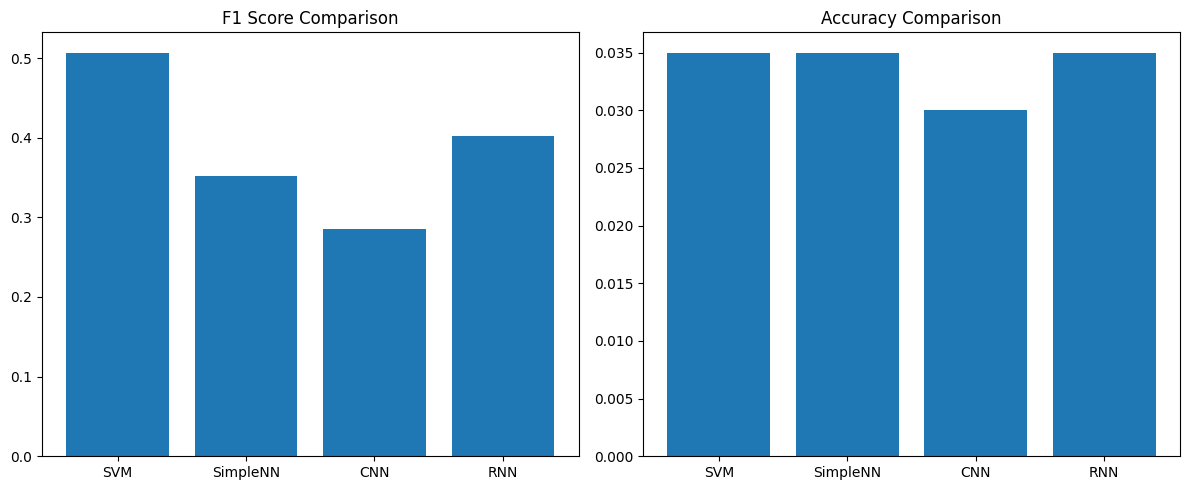

In [22]:
import matplotlib.pyplot as plt

results = [
    {"Model": "SVM", "F1": svm_f1, "Accuracy": svm_accuracy},
    {"Model": "SimpleNN", "F1": best_simple_nn_f1, "Accuracy": best_simple_nn_acc},
    {"Model": "CNN", "F1": best_cnn_f1, "Accuracy": best_cnn_acc},
    {"Model": "RNN", "F1": best_rnn_f1, "Accuracy": best_rnn_acc}
]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar([x["Model"] for x in results], [x["F1"] for x in results])
plt.title("F1 Score Comparison")

plt.subplot(1, 2, 2)
plt.bar([x["Model"] for x in results], [x["Accuracy"] for x in results])
plt.title("Accuracy Comparison")

plt.tight_layout()
plt.savefig("model_comparison.png")

# CROSS VALIDATION

In [23]:

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score
import torch
from torch.utils.data import TensorDataset, DataLoader

def cross_validate(model_type, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []
    input_size = X.shape[1]
    output_size = y.shape[1]
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n=== {model_type} Fold {fold + 1}/{n_splits} ===")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        if model_type == 'SVM':
            model = MultiOutputClassifier(SVC(kernel='linear', probability=True))
            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            
        else:
            if model_type == 'SimpleNN':
                model = SimpleNN(input_size=input_size, output_size=output_size)
            elif model_type == 'CNN':
                model = TextCNN(input_dim=input_size, output_dim=output_size)
            elif model_type == 'RNN':
                model = TextRNN(input_size=input_size, output_size=output_size)
                
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=1e-4)
            
            train_dataset = TensorDataset(
                torch.tensor(X_train, dtype=torch.float32),
                torch.tensor(y_train, dtype=torch.float32)
            )
            val_dataset = TensorDataset(
                torch.tensor(X_val, dtype=torch.float32),
                torch.tensor(y_val, dtype=torch.float32)
            )
            
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            model.train()
            for epoch in range(10): 
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
            
            model.eval()
            val_loader = DataLoader(val_dataset, batch_size=32)
            all_preds, all_labels = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    preds = outputs > 0.5
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            preds = np.array(all_preds)
            y_val = np.array(all_labels)
        
        fold_f1 = f1_score(y_val, preds, average='micro')
        fold_acc = accuracy_score(y_val, preds)
        fold_results.append({'fold': fold+1, 'f1': fold_f1, 'accuracy': fold_acc})
        print(f"Fold {fold+1} - F1: {fold_f1:.4f}, Accuracy: {fold_acc:.4f}")
    
    avg_f1 = np.mean([r['f1'] for r in fold_results])
    avg_acc = np.mean([r['accuracy'] for r in fold_results])
    print(f"\n=== {model_type} cross validation results ===")
    print(f"Average F1: {avg_f1:.4f}")
    print(f"Average Accuracy: {avg_acc:.4f}")
    
    return fold_results

X_cv = X_train.numpy() if isinstance(X_train, torch.Tensor) else X_train
y_cv = y_train.numpy() if isinstance(y_train, torch.Tensor) else y_train

print("Doing cross validation...")

svm_cv_results = cross_validate('SVM', X_cv, y_cv)

simplenn_cv_results = cross_validate('SimpleNN', X_cv, y_cv)

# cnn_cv_results = cross_validate('CNN', X_cv, y_cv)

rnn_cv_results = cross_validate('RNN', X_cv, y_cv)


Doing cross validation...

=== SVM Fold 1/5 ===
Fold 1 - F1: 0.5100, Accuracy: 0.0938

=== SVM Fold 2/5 ===
Fold 2 - F1: 0.4856, Accuracy: 0.0938

=== SVM Fold 3/5 ===
Fold 3 - F1: 0.4847, Accuracy: 0.0750

=== SVM Fold 4/5 ===
Fold 4 - F1: 0.5006, Accuracy: 0.0688

=== SVM Fold 5/5 ===
Fold 5 - F1: 0.4565, Accuracy: 0.0500

=== SVM cross validation results ===
Average F1: 0.4875
Average Accuracy: 0.0763

=== SimpleNN Fold 1/5 ===
Fold 1 - F1: 0.2701, Accuracy: 0.0563

=== SimpleNN Fold 2/5 ===
Fold 2 - F1: 0.2617, Accuracy: 0.0437

=== SimpleNN Fold 3/5 ===
Fold 3 - F1: 0.2294, Accuracy: 0.0312

=== SimpleNN Fold 4/5 ===
Fold 4 - F1: 0.2841, Accuracy: 0.0500

=== SimpleNN Fold 5/5 ===
Fold 5 - F1: 0.2695, Accuracy: 0.0563

=== SimpleNN cross validation results ===
Average F1: 0.2630
Average Accuracy: 0.0475

=== RNN Fold 1/5 ===
Fold 1 - F1: 0.2604, Accuracy: 0.0625

=== RNN Fold 2/5 ===
Fold 2 - F1: 0.1691, Accuracy: 0.0375

=== RNN Fold 3/5 ===
Fold 3 - F1: 0.2025, Accuracy: 0.0250



=== SVM cross validation results ===


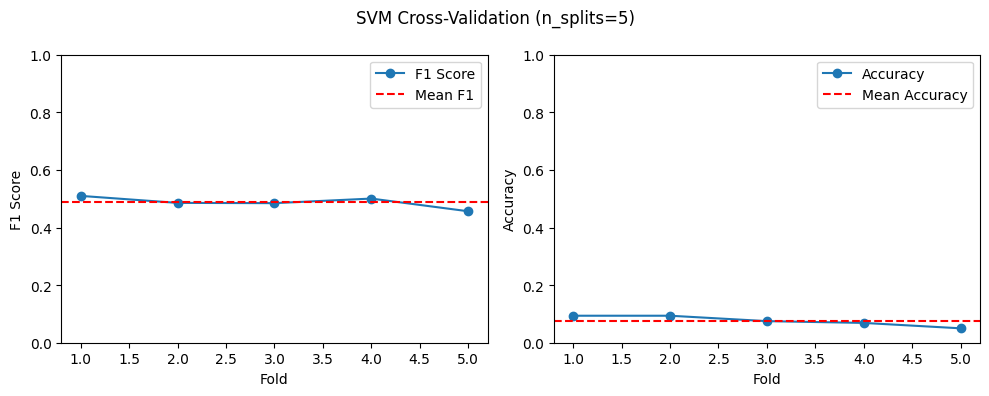

SVM average - F1: 0.4875, Accuracy: 0.0763

=== SimpleNN cross validation results ===


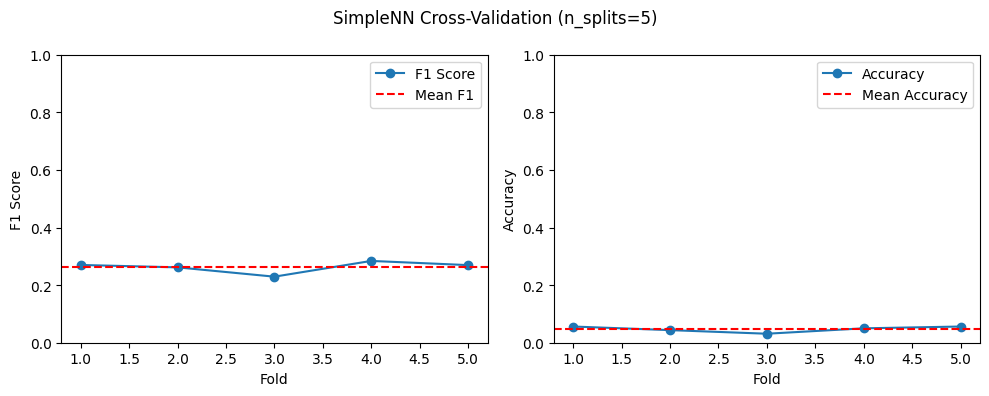

SimpleNN average - F1: 0.2630, Accuracy: 0.0475

=== RNN cross validation results ===


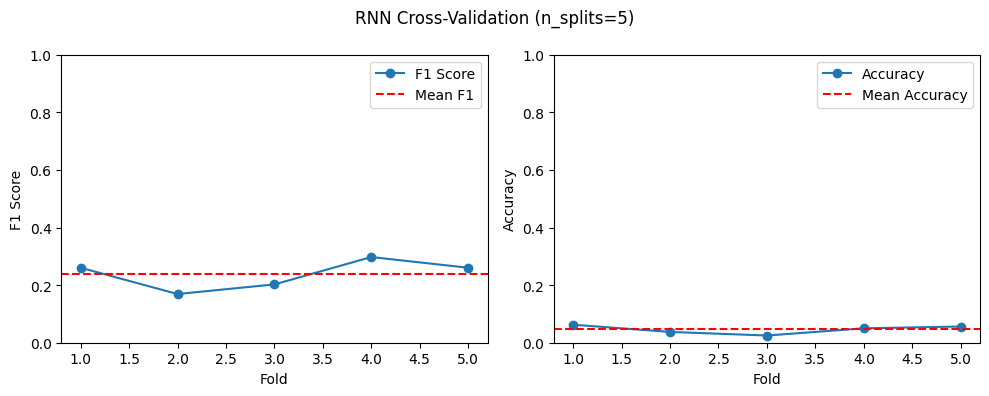

RNN average - F1: 0.2380, Accuracy: 0.0462

=== cross validation results comparison ===
| Model    |   Avg F1 |   Avg Accuracy |
|:---------|---------:|---------------:|
| SVM      | 0.487482 |        0.07625 |
| SimpleNN | 0.262951 |        0.0475  |
| RNN      | 0.237984 |        0.04625 |


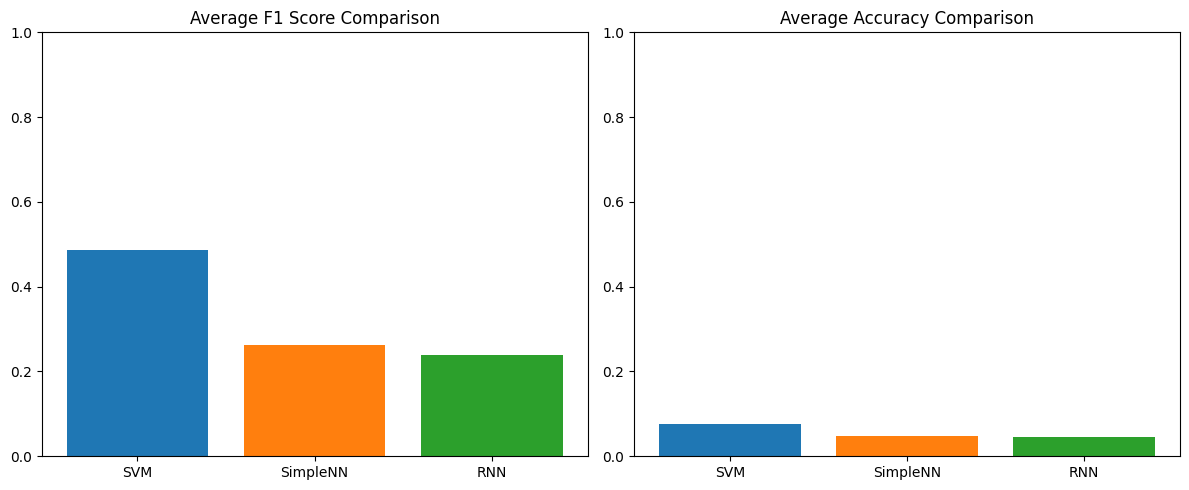

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_cv_results(results_dict, title):
    df = pd.DataFrame(results_dict)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df['fold'], df['f1'], 'o-', label='F1 Score')
    plt.axhline(y=df['f1'].mean(), color='r', linestyle='--', label='Mean F1')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1.0)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(df['fold'], df['accuracy'], 'o-', label='Accuracy')
    plt.axhline(y=df['accuracy'].mean(), color='r', linestyle='--', label='Mean Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.legend()
    
    plt.suptitle(f"{title} Cross-Validation (n_splits={len(df)})")
    plt.tight_layout()
    plt.show()

print("\n=== SVM cross validation results ===")
plot_cv_results(svm_cv_results, "SVM")
print(f"SVM average - F1: {np.mean([r['f1'] for r in svm_cv_results]):.4f}, "
      f"Accuracy: {np.mean([r['accuracy'] for r in svm_cv_results]):.4f}")

print("\n=== SimpleNN cross validation results ===")
plot_cv_results(simplenn_cv_results, "SimpleNN")
print(f"SimpleNN average - F1: {np.mean([r['f1'] for r in simplenn_cv_results]):.4f}, "
      f"Accuracy: {np.mean([r['accuracy'] for r in simplenn_cv_results]):.4f}")

print("\n=== RNN cross validation results ===")
plot_cv_results(rnn_cv_results, "RNN") 
print(f"RNN average - F1: {np.mean([r['f1'] for r in rnn_cv_results]):.4f}, "
      f"Accuracy: {np.mean([r['accuracy'] for r in rnn_cv_results]):.4f}")

print("\n=== cross validation results comparison ===")
results_comparison = {
    "Model": ["SVM", "SimpleNN", "RNN"],  
    "Avg F1": [
        np.mean([r['f1'] for r in svm_cv_results]),
        np.mean([r['f1'] for r in simplenn_cv_results]),
        np.mean([r['f1'] for r in rnn_cv_results])  
    ],
    "Avg Accuracy": [
        np.mean([r['accuracy'] for r in svm_cv_results]),
        np.mean([r['accuracy'] for r in simplenn_cv_results]),
        np.mean([r['accuracy'] for r in rnn_cv_results])  
    ]
}

print(pd.DataFrame(results_comparison).to_markdown(index=False))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(results_comparison["Model"], results_comparison["Avg F1"], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Average F1 Score Comparison")
plt.ylim(0, 1.0)

plt.subplot(1, 2, 2)
plt.bar(results_comparison["Model"], results_comparison["Avg Accuracy"], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Average Accuracy Comparison")
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

wandb.init(project="movie_cross_validation")
wandb.log({
    "svm_cv_f1": results_comparison["Avg F1"][0],
    "svm_cv_acc": results_comparison["Avg Accuracy"][0],
    "simplenn_cv_f1": results_comparison["Avg F1"][1],
    "simplenn_cv_acc": results_comparison["Avg Accuracy"][1],
    "rnn_cv_f1": results_comparison["Avg F1"][2], 
    "rnn_cv_acc": results_comparison["Avg Accuracy"][2], 
    "model_comparison": wandb.Table(dataframe=pd.DataFrame(results_comparison))
})
wandb.finish()

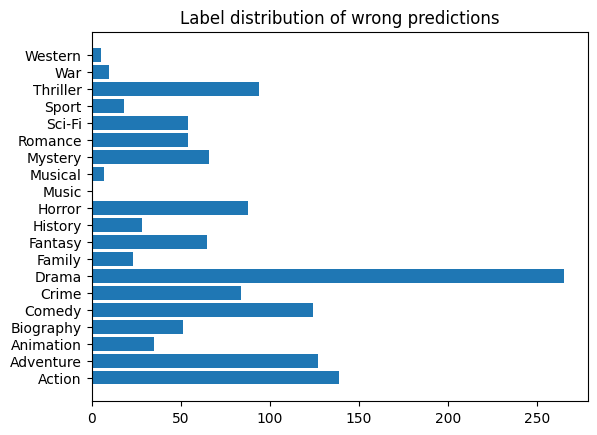

In [25]:
wrong_idx = np.where(svm_pred != y_test.numpy())[0]
wrong_labels = y_test.numpy()[wrong_idx]
wrong_dist = np.sum(wrong_labels, axis=0)
plt.barh(genre_classes, wrong_dist)
plt.title("Label distribution of wrong predictions")
plt.show()